TL; DR: If you need to compute many vector pairwise metrics in batches, try ```sklearn.metrics.pairwise_distances_chunked```

## The problem
I had to compute pairwise [cosine distances](https://en.wikipedia.org/wiki/Cosine_similarity) for a large list of high-dimensional vectors (e.g. [word embedding](https://en.wikipedia.org/wiki/Word_embedding)). 
After a couple of (very bad) possible solutions I found a reasonable one, of course, standing on the shoulders of giants:  the sklearn function ```sklearn.metrics.pairwise_distances_chunked```. 
It is pretty much a one-liner and you don't need to care about manually splitting/parallelizing things. 
This is a quick write-up for other people to save that time.

The intuition behind the computation we want to achieve is depicted in the following plot:

<center>
    <img src="../images/divide-and-conquer/vector-distances.png" height="200">
</center>

*Two vectors in 2D space represented as points. The blue line shows the _euclidean_ distance between the vectors. The $\cos(\alpha)$ is the _cosine_ distance.*

In [ ]:
#| code-fold: true

# Import everything we need
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances_chunked
from tqdm import tqdm
import seaborn as sns

sns.set(context="notebook", font_scale=1.4, style="whitegrid")

For the sake of presentation and simplicity, we are just going to create and use a bunch of random vectors.
And that bunch is going to be relatively large (to compute on a not-so-large laptop).

Let's first get an idea of how many values need to compute if we take say 50 thousand vectors, which is not unrealistic at all (e.g., that could be taking all nouns of a word embedding):

In [ ]:
n_vectors = 50_000
print("Number of pairwise distances to be computed", int(n_vectors * (n_vectors-1) / 2))

Number of pairwise distances to be computed 1249975000


Oh, that is indeed quite a few of them.

## The default solution
The most straight forward to do this is with scipy/sklearn pairwise distances functions as follows (we are going to time it to get an idea of how the problem scales).

In [ ]:
%%time

n_vectors = 5_000
n_dimensions = 300   

all_vectors = np.random.random(size=(n_vectors, n_dimensions))

# Compute pairwise distances with function from sklearn
distances = cosine_distances(all_vectors)

CPU times: user 1.53 s, sys: 347 ms, total: 1.88 s
Wall time: 286 ms


So far, so good. 
But what happens if we want to compute it for more vectors?

In [ ]:
%%time

n_vectors = 15_000

all_vectors = np.random.random(size=(n_vectors, n_dimensions))
distances = cosine_distances(all_vectors)

CPU times: user 5.75 s, sys: 3.22 s, total: 8.97 s
Wall time: 1.99 s


As we see, we have 3 times more vectors, but the computation takes ~9 times longer!
The reason for that is that the complexity of the problem scales non-linearly with the size of the input (number of vectors).
In particular, the complexity is $O(n^2)$, since we are filling the upper half of a square matrix, which grows as the square of number of vectors divided by two (which does not count for the limit case).

In practice, we don't care much about those calculations as long as our computer is able to manage it in a reasonable time.

So how about having more vectors, say 30 or 50 thousand?

### Closer look at the scaling
Let's examine the computational complexity we mentioned above with some quick numerical experiments.

In [ ]:
#| code-fold: true
def evaluate_scaling(func, n_vectors_vals, n_dimensions=300):
    """Return times of func execution for n_vectors_vals"""
    times = []
    for n_vectors in tqdm(n_vectors_vals):
        all_vectors = np.random.random(size=(n_vectors, n_dimensions))  
        st = time.time()
        distances = func(all_vectors)
        times.append(time.time()-st)
        del distances
    return times

def plot_scaling(n_vectors_vals, times, **kwargs):    
    plt.plot(n_vectors_vals, times, linewidth=3, alpha=.8, **kwargs)
    plt.xlabel("Number of vectors")
    plt.ylabel("Time elapsed (seconds)")
    plt.grid(True, linestyle="--", alpha=0.7)

In [ ]:
n_vectors_vals = np.arange(1000, 20001, 500)
times = evaluate_scaling(cosine_distances, n_vectors_vals)

100%|██████████| 39/39 [00:49<00:00,  1.27s/it]


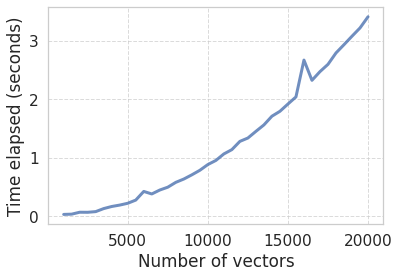

In [ ]:
plot_scaling(n_vectors_vals, times)

We can use what we know about the complexity ($O(n^2)$) to fit a curve.
In other words, we are going to fit a quadratic function that predicts the time it takes to compute all the pairwise distances as a function of the number of vectors.
After that, we can use that function to extrapolate and estimate the performance for a much larger number of vectors.

<center>
<img src="../images/divide-and-conquer/xkcd-extrapolating.png">
</center>

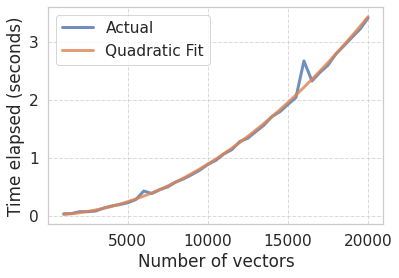

In [ ]:
# Fit a 2nd degree polynomial and get the polynomial evaluator
fit = np.polyfit(n_vectors_vals, times, 2)  
poly = np.poly1d(fit)

# Check our fit
plot_scaling(n_vectors_vals, times, label="Actual")
plot_scaling(n_vectors_vals, poly(n_vectors_vals), label="Quadratic Fit")
plt.legend();

The fit looks approximately correct.
Remember, we don't need to get a perfectly accurate estimate.
We rather want to know if we should grab a coffee while the computation runs, let it compute overnight or if it is unfeasible with our hardware.

Now we extrapolate for more vectors:

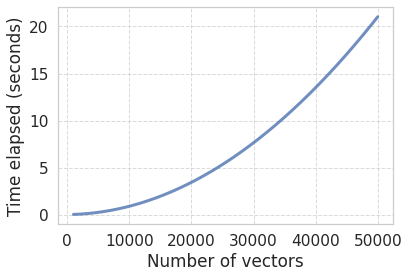

In [ ]:
n_vectors_large = np.arange(1000, 50000)
plot_scaling(n_vectors_large, poly(n_vectors_large))

Well that doesn't sound too bad: it should take around 40 seconds to compute the distances for 50 thousand vectors. <br>
Let's give it a try:

In [ ]:
n_vectors = 50_000

all_vectors = np.random.random(size=(n_vectors, n_dimensions))
distances = cosine_distances(all_vectors)

```
[I 15:19:07.791 LabApp] KernelRestarter: restarting kernel (1/5), keep random ports
kernel 4055ff16-c49b-4a76-9068-e899d001fb85 restarted
```

Ups!
We've blown up the memory and forced the kernel to commit suicide. <br>
If you're running the code along and 50 thousand still works in your computer, just try a higher number, you'll get there pretty soon.
My machine is fine until ~30 thousand vectors.

In short, what we thought was our initial problem (computation time) is actually secondary (it *would take* less than a minute).
But either the result itself (cosine distances matrix) or other structures during intermediate computations simply don't fit in memory.

## Solution: first attempt
Iterate and compute the values one by one instead of computing it with the ```cosine_distances``` function. <br> 
Spoiler: Bad idea. <br>
Let's see:

In [ ]:
#| code-fold: true
def cosine_distances_iter(all_vectors):
    n_vectors = all_vectors.shape[0]
    distances = np.zeros((n_vectors, n_vectors))
    # D is symmetric, so we don't want to compute twice - just use upper diag indices
    for i, j in zip(*np.triu_indices(n_vectors, k=1)):
        distances[i, j] = cosine(all_vectors[i], all_vectors[j])
    return distances

In [ ]:
n_vectors = 100
all_vectors = np.random.random(size=(n_vectors, n_dimensions))
distances = cosine_distances_iter(all_vectors)

As the distance matrix is symmetric, we don't repeat the computation and thus here we just show the upper triangle.<br>
Each entry $D_{ij}$ of the distance matrix corresponds to the cosine distance between the vectors $i$ and $j$.

In [ ]:
#| code-fold: true
def plot_distances_heatmap(distances):    
    sns.heatmap(
        distances, 
        mask=~np.triu(distances).astype(bool), 
        cbar_kws={"label": "Cosine distance"},
        cmap="magma",
        square=True, 
        xticklabels=False, 
        yticklabels=False,
    )
    plt.title("Distance Matrix")
    plt.show()

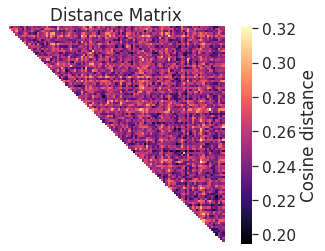

In [ ]:
plot_distances_heatmap(distances)

Now, how does it scale? We can do the same curve fitting as above and project for a larger number of vectors.

100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


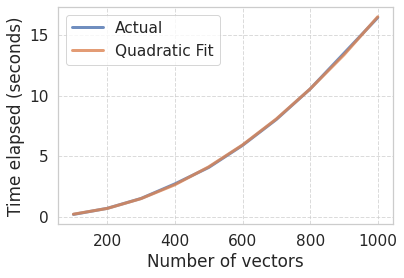

In [ ]:
#| code-fold: true
n_vectors_vals = np.arange(100, 1001, 100)
times = evaluate_scaling(cosine_distances_iter, n_vectors_vals)

# Fit a 2nd degree polynomial and get the polynomial evaluator
fit = np.polyfit(n_vectors_vals, times, 2)  
poly = np.poly1d(fit)

# Check our fit
plot_scaling(n_vectors_vals, times, label="Actual")
plot_scaling(n_vectors_vals, poly(n_vectors_vals), label="Quadratic Fit")
plt.legend();

And the extrapolation looks like this:

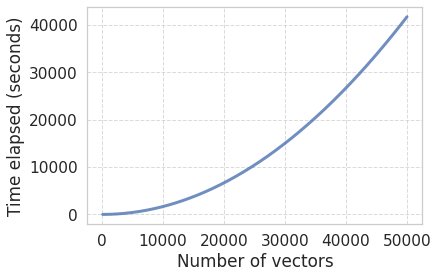

In [ ]:
#| code-fold: true
n_vectors_large = np.arange(100, 50001, 100)
plot_scaling(n_vectors_large, poly(n_vectors_large))

That is going to take a while – way longer than grabbing a coffee. <br>
*Conclusion*: there must be a better way!

## Same giants, same shoulders: **scikit-learn** to the rescue
A much better alternative was to look into the scikit-learn library. <br>
It turns out there is a function ```pairwise_distances_chunked```, which does exactly what we want.
As the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_chunked.html) explains, this function creates a Python *generator* that will build up a distance matrix *chunk by chunk*, thus computing the distances as lazily and returning the intermediate results.
The following example will be hopefully useful:

In [ ]:
n_vectors = 20_000
n_dimensions = 100 

all_vectors = np.random.random(size=(n_vectors, n_dimensions))

# We create an empty placeholder for the results, so that we 
# can visualize the intermediate steps
distances = np.zeros((n_vectors, n_vectors))

Instead of computing and storing *all* the results, we construct the generator first:

In [ ]:
chunk_generator = pairwise_distances_chunked(all_vectors, metric="cosine")
type(chunk_generator)

generator

Now we can call the next method and so generate the first chunk of results. <br>
Like with any other Python generator, we can repeat that call until the generator is exhausted. 

In [ ]:
chunk1 = next(chunk_generator)
print("Shape of chunk 1:", chunk1.shape)
chunk2 = next(chunk_generator)
print("Shape of chunk 2:", chunk2.shape)
chunk3 = next(chunk_generator)
print("Shape of chunk 3:", chunk3.shape)

print("Total size along first dimension :", sum((chunk1.shape[0], chunk2.shape[0], chunk3.shape[0])))

Shape of chunk 1: (6710, 20000)
Shape of chunk 2: (6710, 20000)
Shape of chunk 3: (6580, 20000)
Total size along first dimension : 20000


As we observe on the shape of the generated results, the rendered chunk is a *vertical slice* of the complete distance matrix. <br>
We can visualize it (yellow corresponds to the computed values):

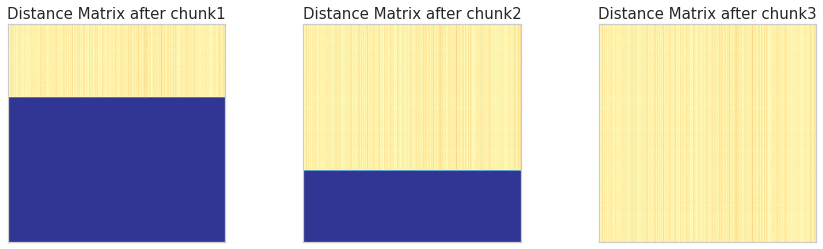

In [ ]:
#| code-fold: true
# WARNING: running this cell might take quite a bit of memory

chunk_generator = pairwise_distances_chunked(all_vectors, metric="cosine")

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
chunks_idx = range(1, 4)  # this depends on the number of total chunks (which I happen to know is 3 here)
current_row = 0
distances = np.zeros((n_vectors, n_vectors))
for ax, c in zip(axes.flat, chunks_idx):
    chunk = next(chunk_generator)
    n_rows, _ = chunk.shape
    # Update distances matrix
    distances[current_row: current_row + n_rows, :] = chunk
    current_row += n_rows    
    ax.imshow(distances, cmap="RdYlBu_r")        
    ax.set_title(f"Distance Matrix after chunk{c}", fontsize=15)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

:::{.callout-note}

The size of each chunk will be figured out automatically by scikit-learn, no need to worry about that. If the results are small enough, it might just dispatch it all in one batch.

:::

### Back to 50K
So far so good. 
But our original problem was substantially larger than the example above, namely 50 (not 20) thousand vectors, which we already saw translates into many more computations. <br>

Now we are going to test the chunked approach with more vectors – that's what you came for :)

In [ ]:
n_vectors = 50_000
n_dimensions = 300 
all_vectors = np.random.random(size=(n_vectors, n_dimensions))

chunk_generator = pairwise_distances_chunked(all_vectors, metric="cosine")

Assuming the final whole array fits in memory, we could collect all chunks and then concatenate them, like this:
```python
distances = np.vstack(chunk_generator)
```
which is very nice, but will stop working with numpy 1.16, thus we need another container

In [ ]:
# This might take a lot of RAM, so depending on your hardware you might just skip the concatenation
distances = np.vstack([chunk for chunk in chunk_generator])
print("distances shape: ", distances.shape)

distances shape:  (50000, 50000)


**Voilà!** <br>
We just computed the pairwise cosine distance for the _50 thousand_ vectors!
If your matrix distance is too big such that cannot be concatenated into one array, then you can simply do whatever you need to with the individual chunks and save the intermediate results.

For the sake of completeness, let's evaluate the scaling of that function:

In [ ]:
#| code-fold: true
def cosine_distance_chunks(all_vectors):
    chunk_generator = pairwise_distances_chunked(all_vectors, metric="cosine")
    return np.vstack([chunk for chunk in chunk_generator])  

100%|██████████| 5/5 [01:10<00:00, 14.12s/it]


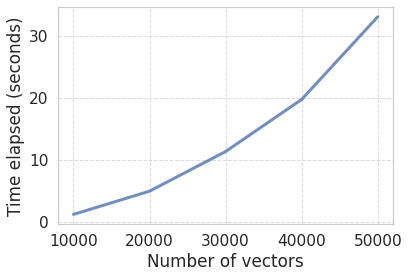

In [ ]:
n_vectors_vals = np.arange(10_000, 50_001, 10_000)
times = evaluate_scaling(cosine_distance_chunks, n_vectors_vals)

plot_scaling(n_vectors_vals, times)

### Sanity check: compare to pure sklearn function

In [ ]:
n_vectors = 30_000
n_dimensions = 300 
all_vectors = np.random.random(size=(n_vectors, n_dimensions))

distances_skl = cosine_distances(all_vectors)
distances_chunk = cosine_distance_chunks(all_vectors)

np.allclose(distances_skl, distances_chunk)

True

:::{.callout-tip}

```pairwise_distances_chunked``` has some parameters that can be pretty useful: <br> - n_jobs: distribute the computation across cores (though you might want to experiment a bit since overhead might make it actually worse). <br> - metric: choose a metric different from cosine distance[1], such as euclidean distance or even your own defined function. <br> You can check the rest of them in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances_chunked.html). <br>

:::

[1]: The sharp eye might have noticed that the term "metric" is not quite correct here. Strictly speaking cosine distance is not a metric (the reason for that can be found [here](https://en.wikipedia.org/wiki/Cosine_similarity)).

Take home message:
Whenever you find yourself carrying out an data/machine learning task and you have the feeling that there must be a better way, check scikit-learn first.
The odds that you'll find something useful are really on your side.

References:
  - [xkcd comic - extrapolation](http://xkcd.com/605/)

<div style="text-align: right; font-size: 40px; font-family: 'Inconsolata', monospace;">
  /Fin
</div>
    
<div style="font-family: 'Inconsolata', monospace;">
Any bugs, questions, comments, suggestions? Ping me on [twitter](https://www.twitter.com/fabridamicelli) or drop me an e-mail (fabridamicelli at gmail).  
Share this article on your favourite platform:
</div>